# Part 1

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
from sklearn.model_selection import train_test_split


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [13]:
df = pd.read_excel('Pumpkin_Seeds_Dataset.xlsx')


In [3]:
x = df[['Area', 'Convex_Area', 'Eccentricity', 'Compactness', 'Aspect_Ration']].copy()

labels = x.columns.to_list()
y = df['Class']
y_map = {label: value for value, label in enumerate(np.unique(y))}
y_labeled = y.map(y_map).values

x_train, x_test, y_train, y_test = train_test_split(x, y_labeled, test_size=0.3, random_state=42)

In [4]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
labels.insert(0, "Intercept")
scaler = StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_train_scaled_int = np.hstack((np.ones((x_train_scaled.shape[0], 1)), x_train_scaled))
x_test_scaled_int = np.hstack((np.ones((x_test_scaled.shape[0], 1)), x_test_scaled))

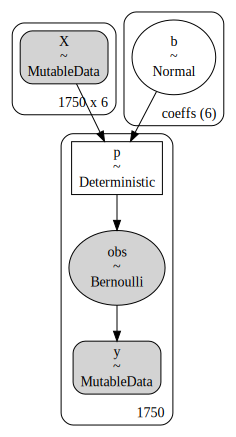

In [9]:
coords = {"coeffs": labels}

with pm.Model(coords=coords) as model:
    # data containers
    X = pm.MutableData("X", x_train_scaled_int)
    y = pm.MutableData("y", y_train)
    # priors
    b = pm.Normal("b", mu=0, sigma=1, dims="coeffs")
    # linear model
    mu = pm.math.dot(X, b)
    # link function
    p = pm.Deterministic("p", pm.invlogit(mu)) 
    # likelihood
    obs = pm.Bernoulli("obs", p=p, observed=y)


In [10]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 79 seconds.


array([[<Axes: title={'center': 'b'}>, <Axes: title={'center': 'b'}>]],
      dtype=object)

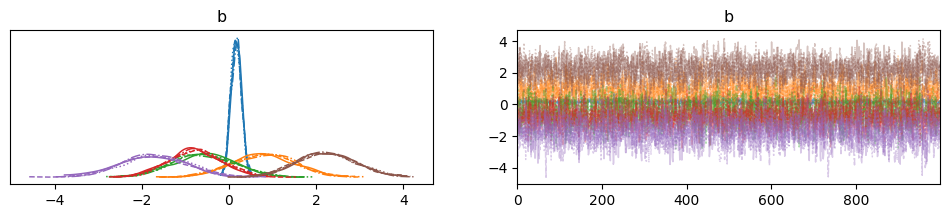

In [14]:
az.plot_trace(idata, var_names=["b"], compact=True)

# Part 2

### Ridge regression:

Log-Likelihood is proportional to: 
$$\log p(y|X,\beta) = -\frac{1}{2}(y - X\beta)^T(y - X\beta)
$$
Log-Prior (Normal Distribution with mean zero and variance $s_i^2$): 
$$\log p(\beta_i) = -\frac{1}{2s_i^2}\beta_i^2
$$

Log-Posteritor:
$$\log p(\beta|y,X) = \log p(y|X,\beta) + \log p(\beta)
$$ 
$$\log p(\beta|y,X) = -\frac{1}{2}(y - X\beta)^T(y - X\beta) -\frac{1}{2s_i^2}\sum_{i=1}^{n}\beta_i^2
$$

If we redefine $\lambda = \frac{1}{2s_i^2}$:
$$\log p(\beta|y,X) = -\frac{1}{2}(y - X\beta)^T(y - X\beta) - \lambda \sum_{i=1}^{n}\beta_i^2
$$

### Lasso regression:

For the lasso regression case, we assume a Laplace prior for each $\beta_i$ with mean 0 and scale parameter $s_i$. The log prior is then:
$$\log p(\beta_i) = -\frac{|\beta_i|}{s_i}
$$

The log posterior is again the sum of the log likelihood and the log prior:

$$\log p(\beta|y,X) = -\frac{1}{2}(y - X\beta)^T(y - X\beta) - \frac{1}{s_i}\sum_{i=1}^{n}|\beta_i|
$$

If we redefine $\lambda = \frac{1}{s_i^2}$:
$$\log p(\beta|y,X) = -\frac{1}{2}(y - X\beta)^T(y - X\beta) - \lambda \sum_{i=1}^{n}|\beta_i|
$$